In [1]:
import numpy as np

import pandas as pd

%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split)

import sklearn
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from sklearn.preprocessing import StandardScaler

import joblib

from libs.container import Container
import dataset

In [2]:
cpu = joblib.cpu_count()

In [3]:
_, sdata, _ = dataset.load_tile_clf()

df = pd.concat([sdata.b278, sdata.b261])

cls = {name: idx for idx, name in enumerate(df.tile.unique())}
df["cls"] = df.tile.apply(cls.get)

print(cls)

del sdata

{'b278': 0, 'b261': 1}


In [4]:
cls = {v: v for v in cls.values()}

In [5]:
BEST_PARAMS = joblib.load("results/hp_selection.pkl.bz2")

In [6]:
SVC_LINEAR_PARAMS = BEST_PARAMS["svc_linear"].best_params_
SVC_RBF_PARAMS = BEST_PARAMS["svc_rbf"].best_params_
KNN_PARAMS = BEST_PARAMS["knn"].best_params_
RF_PARAMS = BEST_PARAMS["rf"].best_params_

del BEST_PARAMS

In [7]:
def execute_kfold(clf_name, clasificator, sample,  X_columns, y_column, nfolds):
    
    skf = StratifiedKFold(n_splits=nfolds)
    
    X = sample[X_columns].values
    y = sample[y_column].values
    
    probabilities = None
    predictions = np.array([])
    y_tests = np.array([])
    
    for train, test in skf.split(X, y):
        x_train = X[train]
        y_train = y[train]
        x_test = X[test]
        y_test = y[test]
        
        clf = sklearn.clone(clasificator)
        clf.fit(x_train, y_train)
        
        current_pred = clf.predict(x_test)
        current_prob = clf.predict_proba(x_test)
        
        y_tests = np.hstack([y_tests, y_test])
        predictions = np.hstack([predictions, current_pred])
        probabilities = (
                current_prob if probabilities is None else
                np.vstack([probabilities, current_prob ]))
            
    fpr, tpr, thresholds = metrics.roc_curve(
        y_tests, 1.-probabilities[:,0], pos_label=1)
    prec_rec_curve = metrics.precision_recall_curve(
        y_tests, 1.- probabilities[:,0], pos_label=1)
    
    roc_auc = metrics.auc(fpr, tpr)
    
    print(metrics.classification_report(y_tests, predictions))
    print("-" * 80)
    
    result = Container({
        "clf_name": clf_name,
        "nfolds": nfolds,
        'fpr': fpr,
        'tpr': tpr,
        'thresh': thresholds,
        'roc_auc': roc_auc,
        'prec_rec_curve': prec_rec_curve,
        'real_cls': y_tests,
        'predictions': predictions,
        'probabilities': probabilities,
        'confusion_matrix': metrics.confusion_matrix(y_tests, predictions)})    
    return result

In [8]:
%%time
rf = execute_kfold(
    clf_name="RF", 
    clasificator=RandomForestClassifier(**RF_PARAMS), 
    sample=df, X_columns=dataset.FEATURES, y_column="cls", nfolds=10)

              precision    recall  f1-score   support

         0.0       0.77      0.80      0.78      2436
         1.0       0.77      0.74      0.76      2252

    accuracy                           0.77      4688
   macro avg       0.77      0.77      0.77      4688
weighted avg       0.77      0.77      0.77      4688

--------------------------------------------------------------------------------
CPU times: user 36min 46s, sys: 3.57 s, total: 36min 49s
Wall time: 3min 51s


In [9]:
%%time
svm_rbf = execute_kfold(
    clf_name="SVM-RBF", 
    clasificator=SVC(**SVC_RBF_PARAMS), 
    sample=df, X_columns=dataset.FEATURES, y_column="cls", nfolds=10)

              precision    recall  f1-score   support

         0.0       0.81      0.80      0.81      2436
         1.0       0.79      0.80      0.79      2252

    accuracy                           0.80      4688
   macro avg       0.80      0.80      0.80      4688
weighted avg       0.80      0.80      0.80      4688

--------------------------------------------------------------------------------
CPU times: user 4min 27s, sys: 135 ms, total: 4min 27s
Wall time: 4min 27s


In [10]:
svm_linear = execute_kfold(
    clf_name="SVM-Linear", 
    clasificator=SVC(**SVC_LINEAR_PARAMS), 
    sample=df, X_columns=dataset.FEATURES, y_column="cls", nfolds=10)

              precision    recall  f1-score   support

         0.0       0.87      0.84      0.85      2436
         1.0       0.83      0.86      0.85      2252

    accuracy                           0.85      4688
   macro avg       0.85      0.85      0.85      4688
weighted avg       0.85      0.85      0.85      4688

--------------------------------------------------------------------------------


In [11]:
knn = execute_kfold(
    clf_name="KNN", 
    clasificator=KNeighborsClassifier(**KNN_PARAMS), 
    sample=df, X_columns=dataset.FEATURES, y_column="cls", nfolds=10)

              precision    recall  f1-score   support

         0.0       0.72      0.68      0.70      2436
         1.0       0.67      0.72      0.70      2252

    accuracy                           0.70      4688
   macro avg       0.70      0.70      0.70      4688
weighted avg       0.70      0.70      0.70      4688

--------------------------------------------------------------------------------


In [12]:
results = [svm_linear, svm_rbf, rf, knn]
joblib.dump(
    value = [r for r in map(dict, results)],
    filename = "results/model_selection.pkl.bz2",
    compress=3)

['results/model_selection.pkl.bz2']

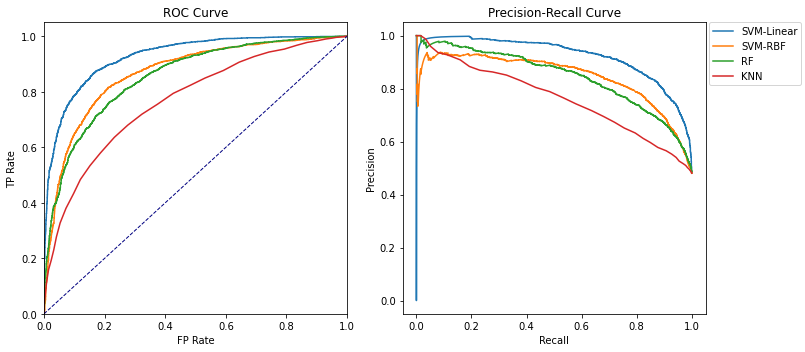

In [13]:
def roc(results, ax=None, labels=True):
    if ax == None:
        ax = plt.gca()

    for res in results:
        cname = "{}".format(res.clf_name)
        label = res.clf_name if labels else "_no_legend_"
        ax.plot(res["fpr"], res["tpr"],  label=label)

    ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('FP Rate')
    ax.set_ylabel('TP Rate')
    ax.set_title('ROC Curve')
    
    return ax


def prc(results, ax=None, labels=True):
    if ax == None:
        ax = plt.gca()
        
    for r in results:
        label = r.clf_name if labels else "_no_legend_"
        ax.plot(r.prec_rec_curve[1], r.prec_rec_curve[0], label=label)
        
    ax.set_title("Precision-Recall Curve")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
roc(results, ax=ax[0])
prc(results, ax=ax[1], labels=False)

lgd = fig.legend(bbox_to_anchor=(1.12, 0.93))
fig.tight_layout();

fig.savefig("plots/cmp_models_curve.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [14]:
import datetime
datetime.datetime.now()

datetime.datetime(2020, 8, 18, 19, 49, 3, 708382)